<a href="https://colab.research.google.com/github/ariesslin/ie7500-g1-tweet-sentiment-nlp/blob/main/scripts/2.%20Data%20Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="background-color:#e6f2ff; border-left:8px solid #0059b3; padding:20px; margin:20px 0;">
  <h2 style="color:#003366;"><strong>2. Data Preprocessing</strong></h2>
  <p style="color:#333333;">Preparing data for model training and testing</p>
</div>

Raw tweet data is often noisy, inconsistent, and full of informal elements like emojis, mentions, hashtags, abbreviations, and inconsistent casing. Cleaning and standardizing this data is a critical step before any meaningful modeling can be done. Effective preprocessing not only improves model performance but also ensures that the insights learned from the data are robust and generalizable.

In this notebook, we apply a series of preprocessing steps tailored specifically to Twitter data, with the goal of simplifying the input while preserving sentiment-relevant patterns. The following steps will be applied to the Sentiment140 dataset:

- Convert all uppercase words to lowercase for consistency
- Replace all Twitter mentions (e.g., `@username`) with the token `"MENTION"` to retain structure without leaking identity-specific information
- Download necessary resources using `nltk.download()` (e.g., `stopwords`, `punkt`)
- Define a custom stopword list by combining standard NLTK stopwords with common punctuation marks (e.g., `,`, `.`, `"`, `'`)
- Remove extra white space and strip leading/trailing spaces

These steps help remove noise while preserving semantic structure, which is especially important for models like LSTM and BERT that are sensitive to input tokenization.

Finally, we will **split the dataset into training and testing subsets** to evaluate the models' generalization performance on unseen data.

This preprocessing pipeline prepares our dataset for vectorization and embedding, enabling classical models like Logistic Regression as well as deep learning architectures to learn from tweet text effectively.


<div style="background-color:#e6f2ff; border-left:8px solid #0059b3; padding:20px; margin:20px 0;">
  <h2 style="color:#003366;"><strong>1. Data Loading & Overview</strong></h2>
  <p style="color:#333333;"></p>
</div>


In [21]:
# importing all libraries here
import gdown
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import html
import numpy as np
import pandas as pd
import gdown
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TreebankWordTokenizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
import spacy
from sklearn.model_selection import train_test_split

In [2]:
# Step 1: Create data directory and download the file
os.makedirs("../data", exist_ok=True)

url = "https://drive.google.com/uc?id=1OeMI3bTQHZrCchkI-vMv2Ibv6RLGk7aS"
output = "../data/sentiment140.csv"

gdown.download(url, output, quiet=False)

# Step 2: Define column names
columns = [
    "target",    # Sentiment (0=negative, 2=neutral, 4=positive)
    "id",        # Tweet ID
    "date",      # Date of tweet
    "flag",      # Query flag
    "user",      # Username
    "text"       # Tweet text
]

# Step 3: Load with proper encoding
df_fixed = pd.read_csv(output, encoding='latin-1', header=None, names=columns)

# Step 4: Fix any garbled characters in 'text' if needed
df_fixed["text"] = df_fixed["text"].apply(lambda x: x.encode("latin1").decode("utf-8", errors="ignore") if isinstance(x, str) else x)

# Step 5: Preview result
print(df_fixed["text"].head())

Downloading...
From (original): https://drive.google.com/uc?id=1OeMI3bTQHZrCchkI-vMv2Ibv6RLGk7aS
From (redirected): https://drive.google.com/uc?id=1OeMI3bTQHZrCchkI-vMv2Ibv6RLGk7aS&confirm=t&uuid=fd334f47-33d5-4775-bea6-6e4f9a2f120d
To: /data/sentiment140.csv
100%|██████████| 239M/239M [00:02<00:00, 84.4MB/s]


0    @switchfoot http://twitpic.com/2y1zl - Awww, t...
1    is upset that he can't update his Facebook by ...
2    @Kenichan I dived many times for the ball. Man...
3      my whole body feels itchy and like its on fire 
4    @nationwideclass no, it's not behaving at all....
Name: text, dtype: object


In [3]:
# we now decode HTML-escaped entities like &quot;, &amp;, etc.
df_fixed['text'] = df_fixed['text'].apply(lambda x: html.unescape(x) if isinstance(x, str) else x)


In [4]:
# Count how many tweets are longer than 140 characters

df_fixed['text_length'] = df_fixed['text'].apply(len)

num_long_tweets = df_fixed[df_fixed['text_length'] > 140].shape[0]
print(f"Number of tweets longer than 140 characters: {num_long_tweets}")

Number of tweets longer than 140 characters: 0


In [5]:
df_fixed['text'].apply(lambda x: pd.isna(x) or str(x).strip() == '').sum()


np.int64(0)

In [6]:
# Disable truncation in display
pd.set_option('display.max_colwidth', None)

# Sort by tweet length and show the top 10 longest tweets
df_fixed.sort_values(by='text_length', ascending=False)[['text', 'text_length']].head(10)

,text,text_length
1599928,dropping molly off getting ice cream with Aaron I want him to meet Manda spending the night with Meredith and Lauren I missed them dearly,138
1599921,I just switched back to Opera (using the moi skin). It's really fast & stable to work with - I'm loving it http://www.opera.com/download/,138
46,"Just checked my user timeline on my blackberry, it looks like the twanking is still happening Are ppl still having probs w/ BGs and UIDs?",138
1022662,"@terraM WORD! If I can get it, it's MINE. Doesn't matter if you put a lid on it, put it behind a cabinet, or kept it behind a closed door",138
521668,"You would think if I continue to block someone, despite the fact they are under a new username each time, I DON'T want them following me!",138
385239,"twitter api is maintaining Tất cả các app g?i api twitter đ?u bị fail trong th?i gian này. (twitterfox on firefox, tweetie on iphone ...)",138
385266,@katiemarie19 Called out 4 the Sharm!! Bad times matey! Not bk till prob about 4am Off 2mrw now so a drive in ure new mo mo is needed xxx,138
887782,"Back from Florida, where we saw manatees and gators and more birds than I can count. Turns out I can row a canoe, but only when I want.",138
1383221,omgomgomomgomg hotties down at the u18 footy club today!! yummy healesville boys cant waaaait hehaha. jess + my plan for next weekend shh,138
385165,good thoughts and feelings about my birthday have gone away. My sister wont stop going on about her car. my mum is in a piss. its raining,138


In [7]:
pd.reset_option('display.max_colwidth')

In [8]:
# Download the stopwords and punkt_tab
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [9]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 4.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [9]:
# step 1, Convert all cases to lower

tweets = df_fixed[['text', 'target']]

tweets['text'] = tweets['text'].str.lower()

tweets.head()

/tmp/ipython-input-9-2406542833.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets['text'] = tweets['text'].str.lower()


,text,target
0,"@switchfoot http://twitpic.com/2y1zl - awww, t...",0
1,is upset that he can't update his facebook by ...,0
2,@kenichan i dived many times for the ball. man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [10]:
# step 2, convert all mentions and the mentioned account names to MENTION

# Make a copy to avoid modifying the original DataFrame
tweets = df_fixed[['text', 'target']].copy()

# Convert to lowercase
tweets['text'] = tweets['text'].str.lower()

# Replace all @mentions with "usermention"
tweets['text'] = tweets['text'].str.replace(r'@\w+', 'usermention', regex=True)

tweets.head()

,text,target
0,"usermention http://twitpic.com/2y1zl - awww, t...",0
1,is upset that he can't update his facebook by ...,0
2,usermention i dived many times for the ball. m...,0
3,my whole body feels itchy and like its on fire,0
4,"usermention no, it's not behaving at all. i'm ...",0


In [11]:
tweets['text'].apply(lambda x: pd.isna(x) or str(x).strip() == '').sum()

np.int64(0)

In [12]:
# Step #3, we tokenize the words and remove stop words

nltk.download('wordnet')

# Load NLP model
nlp = spacy.load('en_core_web_lg')

# Setup
tokenizer = TreebankWordTokenizer()
tweets_array = tweets.to_numpy(copy=True)
stop_words = set(stopwords.words('english'))

# Add extra symbols to stop words
stop_words.update(string.punctuation)
stop_words.update(["''", "'", '``', '’', '“', '”','–', '—', '…', '..', '.', ',', ':', ';', '?', '!', '(', ')', '[', ']', '{', '}', '/', '|'])

# Stemmers / lemmatizers
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Preprocess each tweet
for i in range(len(tweets_array)):
    text = tweets_array[i][0]  # Access the tweet text

    # Remove numbers and whitespace
    text = ''.join((z for z in text if not z.isdigit()))
    text = ' '.join(text.split())

    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)


    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))


    # Tokenize using TreebankWordTokenizer
    tokens = tokenizer.tokenize(text)

    # Remove stopwords but keep usermention
    tokens = [word for word in tokens if word not in stop_words or word == 'usermention']

    # Lemmatize (skip MENTION)
    tokens = [lemmatizer.lemmatize(word.lower()) if word != 'usermention' else word for word in tokens]

    # Rejoin
    tweets_array[i][0] = ' '.join(tokens)

# Convert back to DataFrame
preprocessed_tweets = pd.DataFrame(tweets_array, columns=['text', 'target'])
preprocessed_tweets.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...


,text,target
0,usermention thats bummer shoulda got david car...,0
1,upset cant update facebook texting might cry r...,0
2,usermention dived many time ball managed save ...,0
3,whole body feel itchy like fire,0
4,usermention behaving im mad cant see,0


In [ ]:
preprocessed_tweets['text'].apply(lambda x: pd.isna(x) or str(x).strip() == '').sum()

505

**we have around 500 "new" null text cells introduced after removing stop words. they will be deleted later as a first step before sampling training, validation and testing data**

#### Here we view word cloud of tweets for negative and positive marks

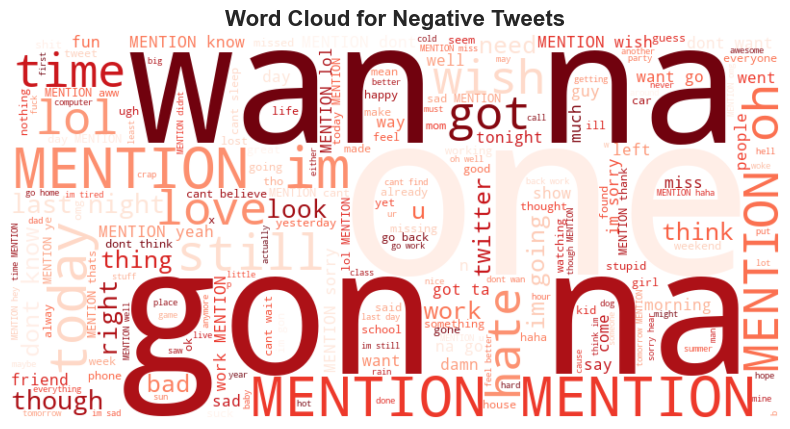

In [ ]:
# Negative Tweets word cloud

# Filter only negative tweets (target == 0)
negative_tweets = preprocessed_tweets[preprocessed_tweets['target'] == 0]['text']

# Combine all negative tweet text into a single string
text_blob = ' '.join(negative_tweets.astype(str))

# Generate word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='Reds',
    max_words=200
).generate(text_blob)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Negative Tweets", fontsize=16, fontweight='bold')
plt.show()

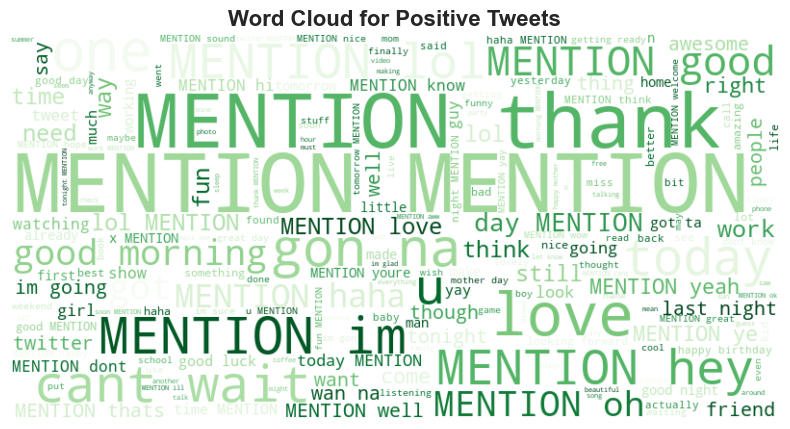

In [ ]:
# Positive Tweets word cloud

# Filter only positive tweets (target == 4)
positive_tweets = preprocessed_tweets[preprocessed_tweets['target'] == 4]['text']

# Combine all negative tweet text into a single string
text_blob = ' '.join(positive_tweets.astype(str))

# Generate word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='Greens',
    max_words=200
).generate(text_blob)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Positive Tweets", fontsize=16, fontweight='bold')
plt.show()

In [ ]:
# We now save the processed tweets to be used later in model development

"""
# Step 1: Save file inside Colab
processed_data_dir = "/content"  # Best practice for Colab
output_processed_file_path = os.path.join(processed_data_dir, 'preprocessed_tweets.csv')
preprocessed_tweets.to_csv(output_processed_file_path, index=False)

print(f"Preprocessed tweets saved to: {output_processed_file_path}")

# Step 2: Download Mac Downloads folder manually
files.download(output_processed_file_path)
"""

print("Save processed file in github as it is less than 100MB")

Save processed file in github as it is less than 100MB


In [ ]:
processed_data_dir = "../processed_data"
os.makedirs(processed_data_dir, exist_ok=True)

output_processed_file_path = os.path.join(processed_data_dir, "preprocessed_tweets.csv")
preprocessed_tweets.to_csv(output_processed_file_path, index=False)

print(f"Preprocessed tweets saved to: {output_processed_file_path}")

Preprocessed tweets saved to: ../processed_data/preprocessed_tweets.csv


#### Next we take first 70% of each negative and positive tweets for training, 15% for validation, and 15% for testing.
Sampling sould be done in a way that respects tweets length distribution.

This way we make sure all models are trained and validated using the same dataset and we have a good ground for fair comparison.

This step is valid because we showed in EDA section that negative and positive tewwts are equally distributed.

In [16]:
# Here, we begin by loading the processed dataset

os.makedirs("../data", exist_ok=True)

file_id = "1LiS2ltl2XfITCamIrERkaa69OKKKoR_r"
url = f"https://drive.google.com/uc?id={file_id}"
output = "../data/preprocessed_tweets.csv"

gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1LiS2ltl2XfITCamIrERkaa69OKKKoR_r
To: /data/preprocessed_tweets.csv
100%|██████████| 78.5M/78.5M [00:00<00:00, 85.1MB/s]


'../data/preprocessed_tweets.csv'

In [18]:
# Read the preprocessed tweet dataset and assign column names
Tweets = pd.read_csv("../data/preprocessed_tweets.csv", header=None, names=["text", "target"])

# Drop any rows where 'text' or 'target' is null
Tweets = Tweets.dropna(subset=["text", "target"])

Tweets.head()

/tmp/ipython-input-18-2271217388.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  Tweets = pd.read_csv("../data/preprocessed_tweets.csv", header=None, names=["text", "target"])


,text,target
0,text,target
1,MENTION thats bummer shoulda got david carr th...,0
2,upset cant update facebook texting might cry r...,0
3,MENTION dived many time ball managed save rest...,0
4,whole body feel itchy like fire,0


In [22]:
# Define bins and labels from the bar chart in our EDA
bin_edges = [0, 20, 40, 60, 80, 100, 120, 140]
bin_labels = ['0–20', '21–40', '41–60', '61–80', '81–100', '101–120', '121–140']

# Step 1: Assign length buckets safely
def assign_length_buckets(df):
    df = df.copy()
    df['text'] = df['text'].fillna('').astype(str)  # Ensure no NaNs
    df['text_length'] = df['text'].str.len()
    df['length_bucket'] = pd.cut(
        df['text_length'],
        bins=bin_edges,
        labels=bin_labels,
        right=True,
        include_lowest=True
    )
    df = df.dropna(subset=['length_bucket'])  # Drop any that didn't fall in bin
    return df

# Step 2: Stratified split function
def stratified_split_by_length_bucket(df_class, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    df_class = assign_length_buckets(df_class)

    # Split into train and temp
    train_df, temp_df = train_test_split(
        df_class,
        test_size=1 - train_ratio,
        stratify=df_class['length_bucket'],
        random_state=42
    )

    # Split temp into validation and test
    val_ratio_adjusted = val_ratio / (val_ratio + test_ratio)
    val_df, test_df = train_test_split(
        temp_df,
        test_size=1 - val_ratio_adjusted,
        stratify=temp_df['length_bucket'],
        random_state=42
    )

    return train_df.drop(columns='length_bucket'), val_df.drop(columns='length_bucket'), test_df.drop(columns='length_bucket')

# Step 3: Filter by sentiment
df_neg = Tweets[Tweets['target'] == 0]
df_pos = Tweets[Tweets['target'] == 4]

# Step 4: Apply stratified splitting
neg_train, neg_val, neg_test = stratified_split_by_length_bucket(df_neg)
pos_train, pos_val, pos_test = stratified_split_by_length_bucket(df_pos)

# Step 5: Combine and shuffle
train_df = pd.concat([neg_train, pos_train]).sample(frac=1, random_state=42).reset_index(drop=True)
val_df = pd.concat([neg_val, pos_val]).sample(frac=1, random_state=42).reset_index(drop=True)
test_df = pd.concat([neg_test, pos_test]).sample(frac=1, random_state=42).reset_index(drop=True)

# Step 6: Extract input and labels
X_train = train_df['text']
y_train = train_df['target']
X_val = val_df['text']
y_val = val_df['target']
X_test = test_df['text']
y_test = test_df['target']

# Final check
print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("Test shape:", test_df.shape)
print("X_train shape:", X_train.shape, "| y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape, "| y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape, "| y_test shape:", y_test.shape)


Train shape: (936194, 3)
Validation shape: (200614, 3)
Test shape: (200614, 3)
X_train shape: (936194,) | y_train shape: (936194,)
X_val shape: (200614,) | y_val shape: (200614,)
X_test shape: (200614,) | y_test shape: (200614,)


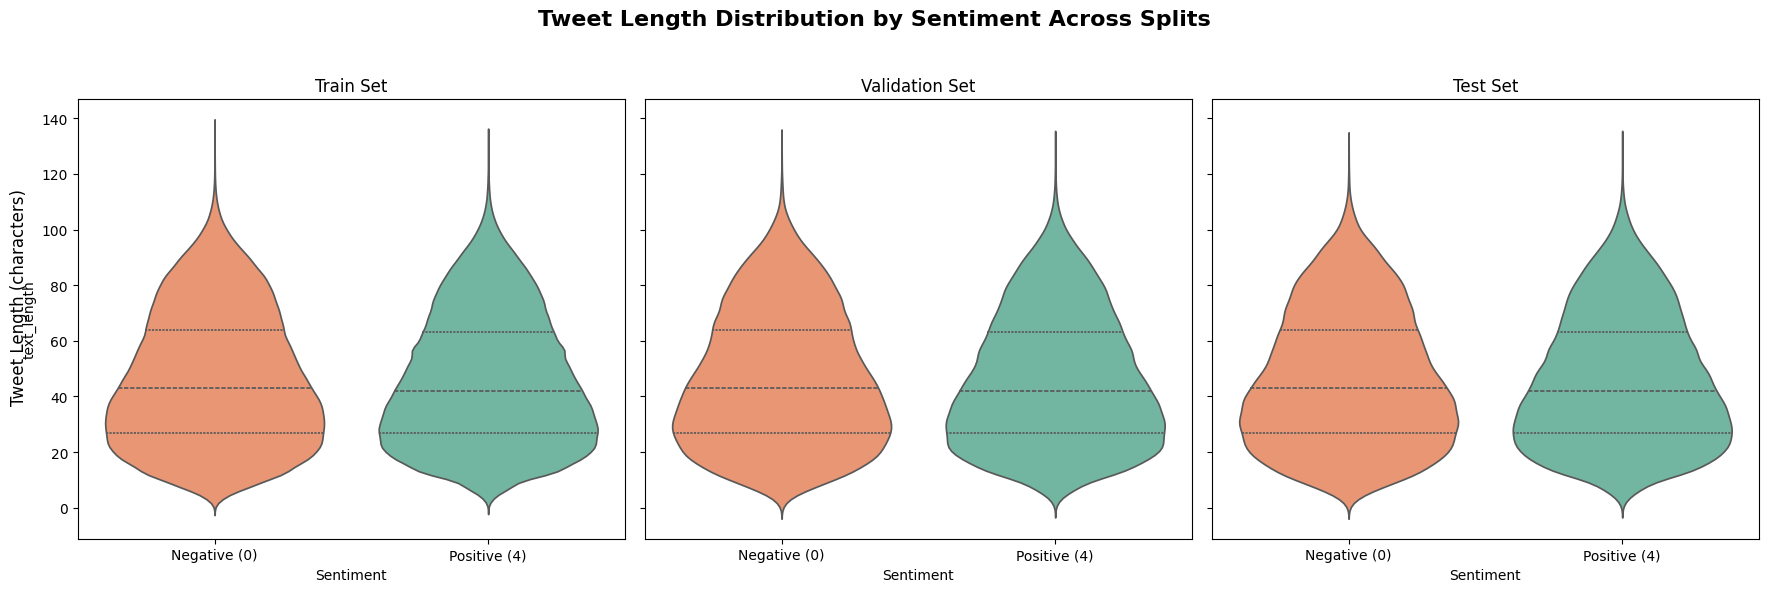

In [23]:
# here we validate the distributions are identical and intact

# Combine text + label for plotting, and calculate text length
train_plot_df = pd.concat([X_train, y_train], axis=1).copy()
val_plot_df = pd.concat([X_val, y_val], axis=1).copy()
test_plot_df = pd.concat([X_test, y_test], axis=1).copy()

# Ensure text_length column is present
train_plot_df['text_length'] = train_plot_df['text'].str.len()
val_plot_df['text_length'] = val_plot_df['text'].str.len()
test_plot_df['text_length'] = test_plot_df['text'].str.len()

# Ensure 'target' is integer (not string) for palette mapping
train_plot_df['target'] = train_plot_df['target'].astype(int)
val_plot_df['target'] = val_plot_df['target'].astype(int)
test_plot_df['target'] = test_plot_df['target'].astype(int)

# Define sentiment color palette
sentiment_palette = {
    0: '#fc8d62',  # Negative
    4: '#66c2a5'   # Positive
}

# Set up subplot layout
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot train
sns.violinplot(ax=axes[0], data=train_plot_df, x='target', y='text_length', hue='target', palette=sentiment_palette, inner='quartile', legend=False)
axes[0].set_title('Train Set')
axes[0].set_xlabel('Sentiment')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Negative (0)', 'Positive (4)'])

# Plot validation
sns.violinplot(ax=axes[1], data=val_plot_df, x='target', y='text_length', hue='target', palette=sentiment_palette, inner='quartile', legend=False)
axes[1].set_title('Validation Set')
axes[1].set_xlabel('Sentiment')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Negative (0)', 'Positive (4)'])

# Plot test
sns.violinplot(ax=axes[2], data=test_plot_df, x='target', y='text_length', hue='target', palette=sentiment_palette, inner='quartile', legend=False)
axes[2].set_title('Test Set')
axes[2].set_xlabel('Sentiment')
axes[2].set_xticks([0, 1])
axes[2].set_xticklabels(['Negative (0)', 'Positive (4)'])

# Shared Y-label and layout
fig.supylabel('Tweet Length (characters)', fontsize=12)
plt.suptitle("Tweet Length Distribution by Sentiment Across Splits", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### After we made sure we have good and valid splits, we now move on to modeling part, where we will only use training and validation set for model comparison and selection, ***testing dataset will only be used in model performance evaluation section***

In [24]:
# Finally, we save splits as CSV to ensure no data leakage takes place as differnt team members split and train the models. this way everyone uses the same training dataset.

import os
import zipfile
import pandas as pd

# Step 1: Save splits locally (optional for inspection or reuse)
train_df.to_csv("train_dataset.csv", index=False)
val_df.to_csv("val_dataset.csv", index=False)
test_df.to_csv("test_dataset.csv", index=False)

# Step 2: Offer download in Colab (optional)
try:
    from google.colab import files
    files.download("train_dataset.csv")
    files.download("val_dataset.csv")
    files.download("test_dataset.csv")
except ImportError:
    print("Not running in Google Colab. Local files saved.")

# Step 3: Save processed datasets to GitHub repo structure
print("Saving split datasets and compressed archive in repository...")

processed_data_dir = "../processed_data" if os.path.exists("../processed_data") else "processed_data"
os.makedirs(processed_data_dir, exist_ok=True)

# Paths to save the individual files
train_path = os.path.join(processed_data_dir, "train_dataset.csv")
val_path = os.path.join(processed_data_dir, "val_dataset.csv")
test_path = os.path.join(processed_data_dir, "test_dataset.csv")

# Save to processed_data/
train_df.to_csv(train_path, index=False)
val_df.to_csv(val_path, index=False)
test_df.to_csv(test_path, index=False)

# Step 4: Create a zip archive of the datasets
zip_path = os.path.join(processed_data_dir, "sentiment140_splits.zip")
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write(train_path, arcname="train_dataset.csv")
    zipf.write(val_path, arcname="val_dataset.csv")
    zipf.write(test_path, arcname="test_dataset.csv")

print(f"Zipped dataset saved to: {zip_path}")
print("Contents of archive:")
with zipfile.ZipFile(zip_path, 'r') as zipf:
    print(zipf.namelist())

print("\n📦 Ready to commit the archive to your GitHub repository:")
print(f"cd to repo folder and run:\n")
print(f"git add {zip_path}")
print(f'git commit -m "Add compressed dataset splits for reproducibility"')
print("git push")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving split datasets and compressed archive in repository...
Zipped dataset saved to: processed_data/sentiment140_splits.zip
Contents of archive:
['train_dataset.csv', 'val_dataset.csv', 'test_dataset.csv']

📦 Ready to commit the archive to your GitHub repository:
cd to repo folder and run:

git add processed_data/sentiment140_splits.zip
git commit -m "Add compressed dataset splits for reproducibility"
git push
